# Additional Data Integration

At the end of the previous notebook (https://jovian.ai/a-mattei3/dataunderstandingv2) we added:
- Poverty % and Inequality Rate at County level
- In-depth cleaning of the death_County attribute
- Join of the various dataframes and export the data, creating a comprehensive csv file

# Task Definition and Description

- Task definition: AI-JUDGE - Predict the legal outcome of a fatal encounter
- Elimination of the rows with Unreported, Suicide and Pending values on the target class
- Show dataset size and class distribution. 
- Oversampling

# Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
directory = '/content/drive/My Drive/Big Data/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports and utils functions

In [ ]:
%matplotlib inline
import os, sys, inspect
#PATH = '/content/drive/My Drive/Big Data/data/'
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_curve, auc, plot_confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

#UTILITY FUNCTIONS

# Plot confusion matrix 
def make_confusion_matrix(cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

#Plot auc curve 
def plot_roc_curve(model, X_test, y_test, name_model):
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=name_model+' (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

#Encode columns
le = preprocessing.LabelEncoder()
def encoder(column): 
  le.fit(police[column])
  le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
  print(le_name_mapping)

  return le.transform(police[column])

#PCA to visualize our data 
from sklearn.decomposition import PCA
import plotly.express as px
from mpl_toolkits import mplot3d

def get_pca(df_x, df_y, tre_d=False):
    pca = PCA(3,random_state=42)
    pca.fit(df_x)
    pca_proj = pca.transform(df_x)

    df_pca = pd.DataFrame()
    df_pca['pca1'] = pca_proj[:,0]
    df_pca['pca2'] = pca_proj[:,1]
    df_pca['pca3'] = pca_proj[:,2]
    df_pca['dispositions_exclusions'] = le.inverse_transform(df_y)
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    c = df_pca['dispositions_exclusions'].apply(lambda x: -1.0 if x == 'Guilty' else 1.0)
    # Creating plot
    ax.scatter3D(df_pca['pca1'], df_pca['pca2'], df_pca['pca3'], c = c)
    plt.title("simple 3D scatter plot")
    # show plot
    plt.show()
    if tre_d:
        total_var = pca.explained_variance_ratio_.sum() * 100

        fig = px.scatter_3d(
            pca_proj, x=0, y=1, z=2, color = df_pca['dispositions_exclusions'],
            title=f'Total Explained Variance: {total_var:.2f}%', 
            labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
        )
        fig.update_layout(
            height=500, width=700
        )
        fig.show()

Load Dataset

In [ ]:
df = pd.read_csv(directory + 'df_final2.csv')
police = df.copy()
del police['Unnamed: 0']
print(police.shape)
police.head()

(27999, 28)


age  gender  ...       president  pres_party
0   17    Male  ...  George W. Bush  Republican
1   24  Female  ...  George W. Bush  Republican
2   40    Male  ...  George W. Bush  Republican
3   43    Male  ...  George W. Bush  Republican
4   47    Male  ...  George W. Bush  Republican

[5 rows x 28 columns]

Delete Rows

In [ ]:
#take dispositions_exclusions to be deleted 
unreported = police[police['dispositions_exclusions'] == "Unreported"]
suicide = police[police['dispositions_exclusions'] == "Suicide"]
pending = police[police['dispositions_exclusions'] == 'Pending']

#delete found rows 
police.drop(unreported.index, axis=0, inplace=True)
police.drop(suicide.index, axis=0, inplace=True)
police.drop(pending.index, axis=0, inplace=True)
police.dropna(inplace = True)

print('Police.shape:', police.shape)

Police.shape: (7838, 28)


Modify Date Attribute

In [ ]:
#Date
police['death_date'] =  pd.to_datetime(police['death_date'])
police['year'] = police['death_date'].dt.year
police['month'] = police['death_date'].dt.month
police.drop(labels=['death_date'], axis=1, inplace=True)

Extract Target Variable

In [ ]:
#Target
target = police[['dispositions_exclusions']]
del police['dispositions_exclusions']

In [ ]:
df_death_cause = pd.get_dummies(police['death_cause']) # for Logistic Regression purpose

Label Encoding

In [ ]:
#Attributes and encoding

numerics_attrs = police.select_dtypes(include=np.number).columns.tolist()
categorical_attrs = list(set(police.columns) - set(numerics_attrs))
print('Categorical attributes:', categorical_attrs, '\n')

for col in categorical_attrs: 
  #print('\n---------------  ' , col, '  ---------------')
  police[col] = encoder(col)

#Target Variable Encoding
le = preprocessing.LabelEncoder()
le.fit(target['dispositions_exclusions'])
target['dispositions_exclusions'] = le.fit_transform(target['dispositions_exclusions'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print('\n Target Variable Mapping:')
print(le_name_mapping)
print(target.value_counts())

police.head()

Categorical attributes: ['statewinner_party', 'race', 'pres_party', 'death_description', 'death_city', 'president', 'state_po', 'use_of_force', 'death_county', 'statewinner', 'death_cause', 'gender', 'mental_illness'] 

{'Democrat': 0, 'Republican': 1}
{'African-American/Black': 0, 'European-American/White': 1, 'Hispanic/Latino': 2, 'Other': 3}
{'Democrat': 0, 'Republican': 1}
{'\rChantel Ortiz, 16, and Cameron Montoya, 18, were killed and three others were seriously injured when a stolen sport utility vehicle they were in crashed during a high-speed chase with a Colorado state trooper in Pueblo.': 0, '"The incident began with a hit-and-run report at 7:30 a.m. Feb. 7 in Chaska. According to police, the suspect vehicle—a red Saab—was located and led police on a high-speed chase on U.S. 212, at times reaching 90 mph and with its hood popped open against the windshield. The chase ended in Eden Prairie when the Saab veered to the shoulder and hit a retaining wall. Police said the driver, M

age  gender  race  mental_illness  ...  president  pres_party  year  month
7    20       1     1               1  ...          2           1  2000      9
44   31       1     2               1  ...          2           1  2000      9
63   85       1     1               2  ...          2           1  2000      2
65   23       1     2               1  ...          2           1  2000      5
92   25       1     1               2  ...          2           1  2000      1

[5 rows x 28 columns]

Split Train-Test and Normalize

In [ ]:
#split on train-test 
X_train, X_test, y_train, y_test = train_test_split(police, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 

print('Target distribytion in train set:')
(unique, counts) = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

#Normalize
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Target distribytion in train set:
[[   0  967]
 [   1 4519]]


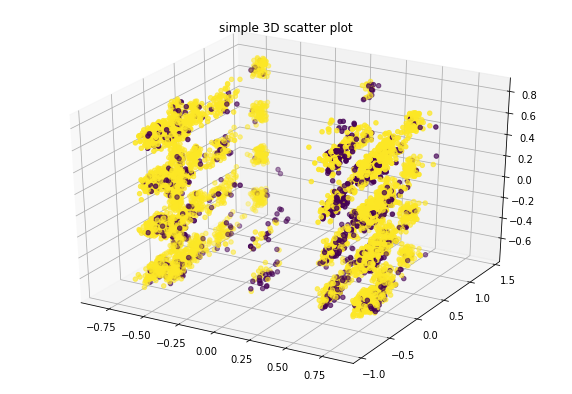

In [ ]:
get_pca(X_train, y_train)

Oversampling

In [ ]:
#Create an Oversampled version of our dataset with SMOTE
smote_over = SMOTE(random_state=42)
X_train_over, y_train_over = smote_over.fit_resample(X_train, y_train)
print('Oversampled Shape', X_train_over.shape, y_train_over.shape)

Oversampled Shape (9038, 28) (9038, 1)


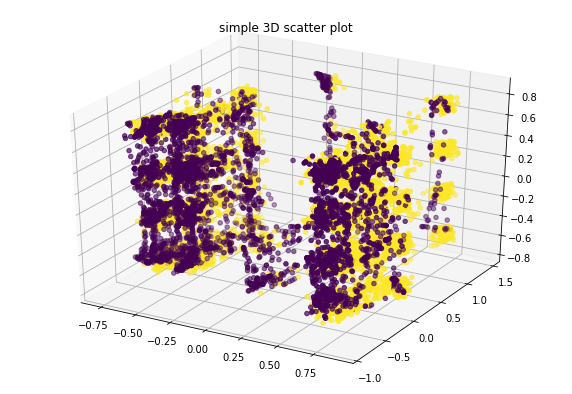

In [ ]:
get_pca(X_train_over, y_train_over)

Create dataset with only the original features

In [ ]:
original = [0,1,2,3,4,5,7,8,9,10,11,12,26,27]

#Train and Test only with original features
X_train_original = X_train[:, original].copy()
X_test_original = X_test[:, original].copy()

#Oversampled Train, only with original features
X_train_over_original = X_train_over[:, original].copy()

# Baselines

- Show the dummy classifiers to set a minimum level of performance for our models

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf1 = DummyClassifier(strategy="most_frequent")
dummy_clf1.fit(X_train, y_train)
y_pred1 = dummy_clf1.predict(X_test)
print('DUMMY CLASSIFIER - MOST FREQUENT')
print('Accuracy %s' % accuracy_score(y_test, y_pred1))
print('F1-score %s' % f1_score(y_test, y_pred1, average=None))
print(classification_report(y_test, y_pred1))

dummy_clf2 = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf2.fit(X_train, y_train)
y_pred2 = dummy_clf2.predict(X_test)
print('DUMMY CLASSIFIER - STRATIFIED')
print('Accuracy %s' % accuracy_score(y_test, y_pred2))
print('F1-score %s' % f1_score(y_test, y_pred2, average=None))
print(classification_report(y_test, y_pred2))

dummy_clf3 = DummyClassifier(strategy="uniform", random_state=42)
dummy_clf3.fit(X_train, y_train)
y_pred3 = dummy_clf3.predict(X_test)
print('DUMMY CLASSIFIER - UNIFORM')
print('Accuracy %s' % accuracy_score(y_test, y_pred3))
print('F1-score %s' % f1_score(y_test, y_pred3, average=None))
print(classification_report(y_test, y_pred3))

DUMMY CLASSIFIER - MOST FREQUENT
Accuracy 0.8239795918367347
F1-score [0.        0.9034965]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       414
           1       0.82      1.00      0.90      1938

    accuracy                           0.82      2352
   macro avg       0.41      0.50      0.45      2352
weighted avg       0.68      0.82      0.74      2352

DUMMY CLASSIFIER - STRATIFIED
Accuracy 0.7130102040816326
F1-score [0.18181818 0.82598608]
              precision    recall  f1-score   support

           0       0.18      0.18      0.18       414
           1       0.83      0.83      0.83      1938

    accuracy                           0.71      2352
   macro avg       0.50      0.50      0.50      2352
weighted avg       0.71      0.71      0.71      2352

DUMMY CLASSIFIER - UNIFORM
Accuracy 0.4906462585034014
F1-score [0.25957973 0.6117952 ]
              precision    recall  f1-score   support

           0       0

# Method

- Models that we tried: Random Forest, Decision Tree, Logistic Regression, Naive Bayes, KNN, SVM, Neural Network 
- List the versions we are going to try for each model:

    1. All features

    2. All features - oversample

    3. Feature selection 

    4. Feature selection - oversampled

    5. Original dataset (without adding any features) 

    6. Original dataset - oversampled 

- We used Cross Validation for parameter tuning, varying the parameter list to try out according to the models. 


# Models

## Decision Tree

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
import sklearn
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import pydotplus
from sklearn import tree
from IPython.display import Image
custom_scorer = make_scorer(f1_score, greater_is_better=True, pos_label=0)
from sklearn.tree import DecisionTreeClassifier

Parameter List for Decision Tree

In [ ]:
param_list_dec_tree = {'criterion': ['entropy', 'gini'],
              'max_depth': list(np.arange(2, 10)),
              'min_samples_split': list(np.arange(2, 100)),
              'min_samples_leaf': list(np.arange(1, 100))
             }  
#RandomSearch
#clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)
#random_search = RandomizedSearchCV(clf, param_distributions=param_list_dec_tree, scoring = custom_scorer, n_iter=1000, n_jobs = -1, random_state=42)
#random_search.fit(X_train, y_train)
#report(random_search.cv_results_, n_top=3)

Best results when fitted on the various train set versions:

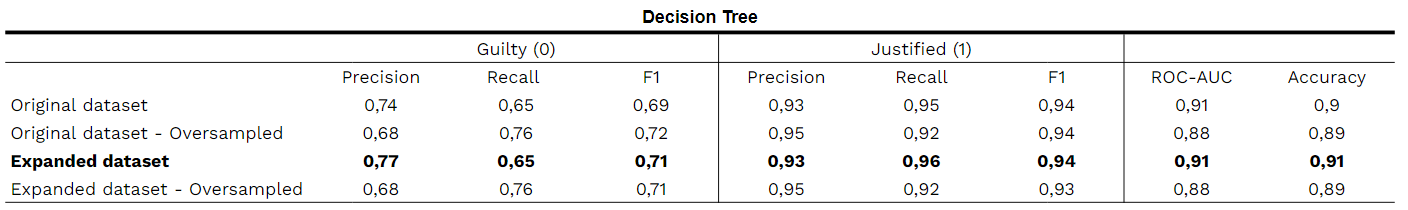

Runnable example for (one of) the best model(s)

Accuracy 0.9056122448979592
F1-score [0.70942408 0.94365482]
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       414
           1       0.93      0.96      0.94      1938

    accuracy                           0.91      2352
   macro avg       0.85      0.81      0.83      2352
weighted avg       0.90      0.91      0.90      2352



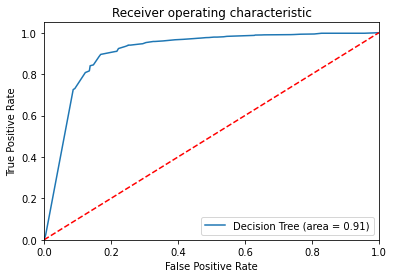

In [ ]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=7, 
                             min_samples_split=9, min_samples_leaf=13)
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
#Print Confusion Matrix and plot roc curve
print('Accuracy %s' % accuracy_score(y_test, y_pred_tree))
print('F1-score %s' % f1_score(y_test, y_pred_tree, average=None))
print(classification_report(y_test, y_pred_tree))
plot_roc_curve(clf_tree, X_test, y_test, 'Decision Tree')

Feature Importance

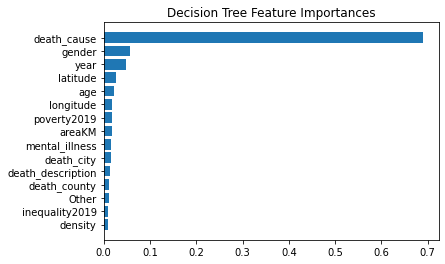

In [ ]:
nbr_features = 15
tree_feature_importances = clf_tree.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]
y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(police.columns)[sorted_idx])
plt.title("Decision Tree Feature Importances")
plt.show()

Decision Tree Plot

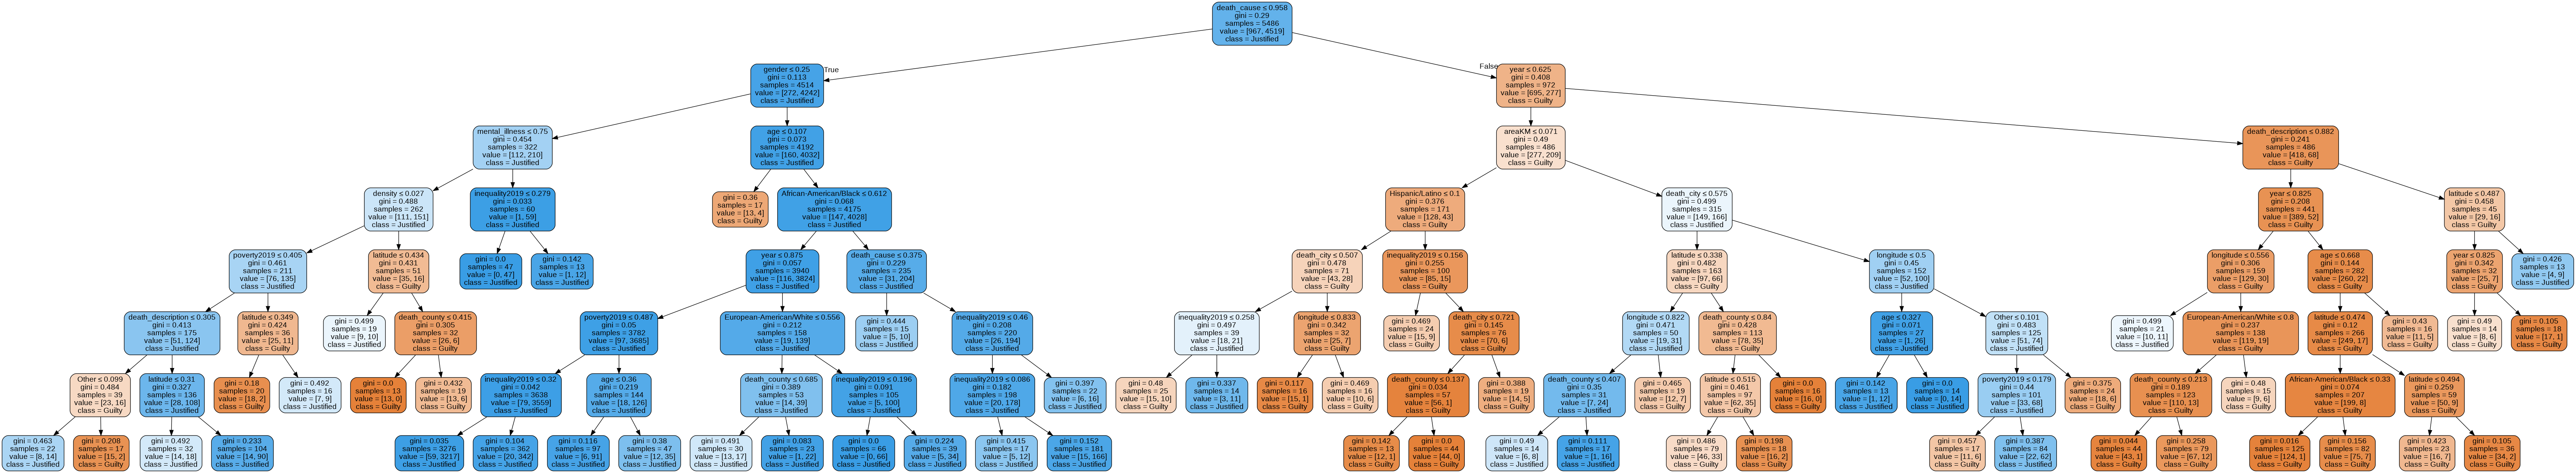

In [ ]:
dot_data = tree.export_graphviz(clf_tree, out_file=None,  
                                feature_names=police.columns, 
                                class_names=['Guilty', 'Justified'],  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pydotplus
from sklearn import tree
from IPython.display import Image
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

Parameter List for Random Forest

In [ ]:
param_list_forest = {'criterion': ['entropy', 'gini'],
                     'n_estimators' : [300, 400, 500, 800, 1000, 1500],
                     'max_features' :  ['auto', 'sqrt', 'log2']  , 
                     'bootstrap' : [True, False],
                    'max_depth': list(np.arange(2, 10)) + [12, 15, 20, 25, None],
                    'min_samples_split': list(np.arange(2, 10)) + list(np.arange(11, 55, 2)),
                    'min_samples_leaf': list(np.arange(1, 10)) + list(np.arange(11, 55, 2)), 
                    'random_state' : [42]
             }  

#clf_forest_CV = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, 
#                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)

#RandomSearch
#randomsearch_forest = RandomizedSearchCV(clf_forest_CV, param_list_forest, cv = 5, scoring = custom_scorer, n_jobs = -1, verbose=10, n_iter=1000)
#randomsearch_forest.fit(X_train, y_train.values.ravel())
#report(randomsearch_forest.cv_results_, n_top=5)'''

Best results when fitted on the various train set versions:

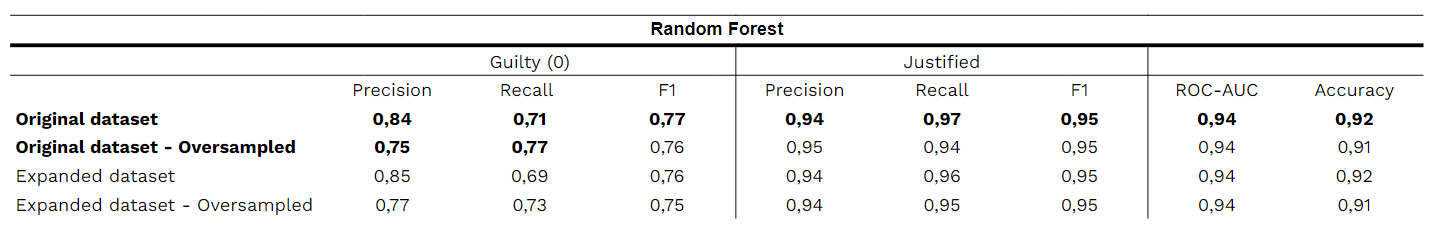

Runnable example for (one of) the best model(s):

Accuracy 0.9238945578231292
F1-score [0.76539974 0.95458006]
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       414
           1       0.94      0.97      0.95      1938

    accuracy                           0.92      2352
   macro avg       0.89      0.84      0.86      2352
weighted avg       0.92      0.92      0.92      2352



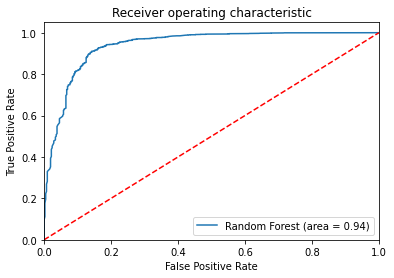

In [ ]:
clf_forest = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=None, min_samples_split=3, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                       random_state=42, bootstrap=False, n_jobs=-1)

clf_forest.fit(X_train_original, y_train)

y_pred_forest = clf_forest.predict(X_test_original)

print('Accuracy %s' % accuracy_score(y_test, y_pred_forest))
print('F1-score %s' % f1_score(y_test, y_pred_forest, average=None))
print(classification_report(y_test, y_pred_forest))
plot_roc_curve(clf_forest, X_test_original, y_test, 'Random Forest')

Feature Importance

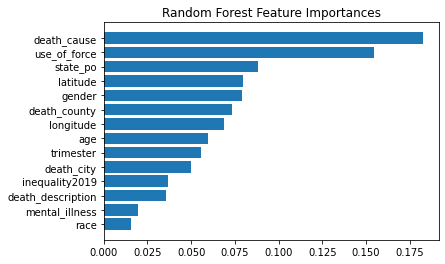

In [ ]:
nbr_features = 15
tree_feature_importances = clf_forest.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]
y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(police.columns)[sorted_idx])
plt.title("Random Forest Feature Importances")
plt.show()

## K-Nearest Neighbors (KNN)

Results obtained in different DataSet. The best results are obtained in the original dataset and in the feature selection performed by the decision tree. But on the feature selection dataset we have more precision on the Guilty class.

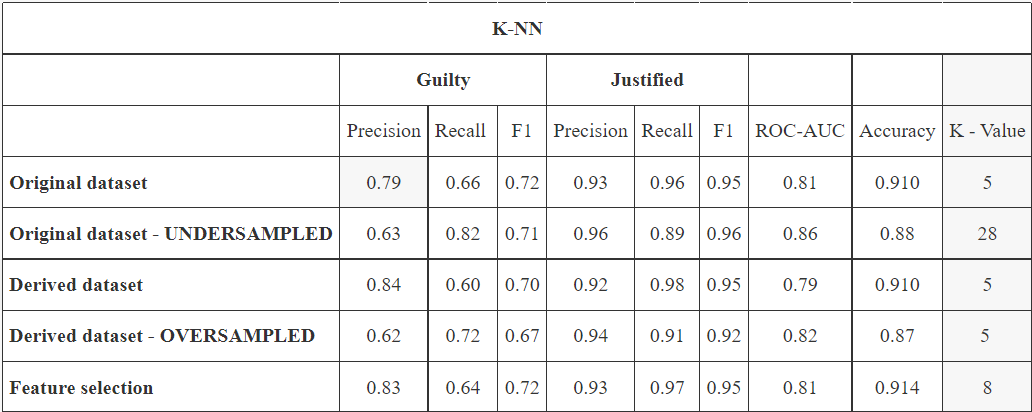

In [ ]:
tree_sel = police.copy()
tree_sel.drop(['mental_illness', 'trimester', 'state_po', 'European-American/White', 'African-American/Black', 'Hispanic/Latino', 'Other', 'areaKM', 'statewinner_party',
         'statewinner', 'president', 'pres_party'], axis=1, inplace=True)            

tree_sel.head()

age  gender  race  death_cause  ...       pop    density  year  month
7    20       1     1            7  ...  33871653  79.891627  2000      9
44   31       1     2            0  ...  33871653  79.891627  2000      9
63   85       1     1            7  ...  33871653  79.891627  2000      2
65   23       1     2            7  ...  33871653  79.891627  2000      5
92   25       1     1            7  ...  33871653  79.891627  2000      1

[5 rows x 16 columns]

In [ ]:
#specify class and features
class_name = 'dispositions_exclusions'
attributes = [col for col in tree_sel if col != class_name]

#Train and Test Sets definition
X = tree_sel[attributes].values
y = target
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X, y, test_size=0.3, random_state=42, stratify=target)

#Normalize
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
scaler.fit(X_train_KNN)
X_train_KNN = scaler.transform(X_train_KNN)
X_test_KNN = scaler.transform(X_test_KNN)

We plot the best K-Value measuring the accuracy 

Maximum accuracy: 0.9047619047619048 at K = 8


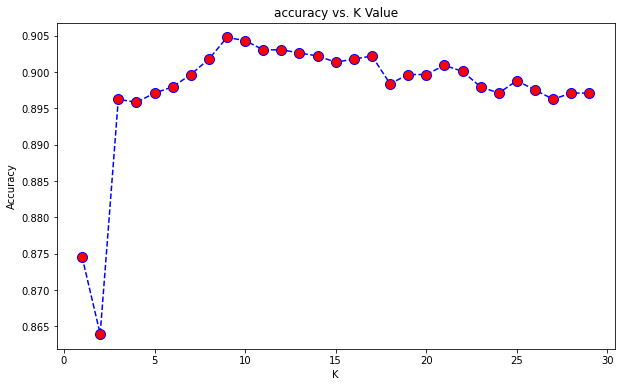

In [ ]:
#plot of the accuracy based on k value
from sklearn.neighbors import KNeighborsClassifier

acc = []
# Will take some time
from sklearn import metrics
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train_KNN,y_train_KNN)
    yhat = neigh.predict(X_test_KNN)
    acc.append(metrics.accuracy_score(y_test_KNN, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,30),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc)))
k_top_over = acc.index(max(acc))

After that we perform a grid search using as parameters the best k-value, the distance metrics and the weights distributions.

In [ ]:
from sklearn.model_selection import GridSearchCV
cv = RepeatedKFold(n_splits=10, n_repeats=3,random_state=42)
grid_params= {'n_neighbors': [k_top_over], 
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
             }

gs = GridSearchCV(
    KNeighborsClassifier(), grid_params, verbose=1, cv=cv, n_jobs=-1)

gs_results = gs.fit(X_train_KNN, y_train_KNN)

gs_results.best_estimator_

Fitting 30 folds for each of 4 candidates, totalling 120 fits


KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')

CV Accuracy: 0.9137 (+/- 0.010)
CV F1-score: 0.8411 (+/- 0.019)
--- --- --- --- --- ---
--- --- --- --- --- ---
Accuracy 0.9141156462585034
F1-score [0.72404372 0.94914401]
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       414
           1       0.93      0.97      0.95      1938

    accuracy                           0.91      2352
   macro avg       0.88      0.81      0.84      2352
weighted avg       0.91      0.91      0.91      2352

--- --- --- --- --- ---
--- --- --- --- --- ---


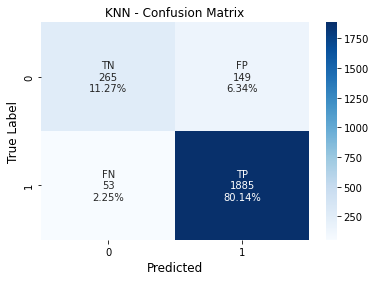

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score 

cv = RepeatedKFold(n_splits=10, n_repeats=3,random_state=42)
cv_scores = cross_val_score(gs_results.best_estimator_, X_train_KNN, y_train_KNN, cv=cv, n_jobs=-1)
print('CV Accuracy: %0.4f (+/- %0.3f)' % (cv_scores.mean(), cv_scores.std()))
f1scores = cross_val_score(gs_results.best_estimator_, X_train_KNN, y_train_KNN, cv=cv, scoring='f1_macro', n_jobs=-1)
print('CV F1-score: %0.4f (+/- %0.3f)' % (f1scores.mean(), f1scores.std()))

print('--- --- --- --- --- ---')
print('--- --- --- --- --- ---')

y_pred = gs_results.best_estimator_.predict(X_test_KNN)
print('Accuracy %s' % accuracy_score(y_test_KNN, y_pred))
print('F1-score %s' % f1_score(y_test_KNN, y_pred, average=None))
print(classification_report(y_test_KNN, y_pred))

print('--- --- --- --- --- ---')
print('--- --- --- --- --- ---')
cf_matrix = confusion_matrix(y_test_KNN, y_pred)
make_confusion_matrix(cf_matrix, 'KNN - Confusion Matrix')

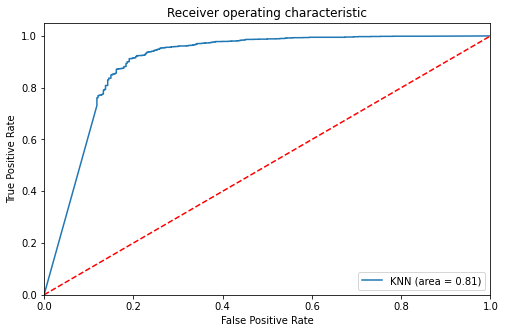

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_auc = roc_auc_score(y_test_KNN, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, gs_results.best_estimator_.predict_proba(X_test_KNN)[:,1])
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN ROC Curve')
plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}
cv_method = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

'''nb_classifier = GaussianNB()
gs_NB = GridSearchCV(estimator = nb_classifier, 
                 param_grid = params_NB, 
                 cv = cv_method,   # use any cross validation technique 
                 scoring = 'f1',
                 verbose = 1) 
gs_NB.fit(X_train, y_train)

gs_NB.best_params_'''

"nb_classifier = GaussianNB()\ngs_NB = GridSearchCV(estimator = nb_classifier, \n                 param_grid = params_NB, \n                 cv = cv_method,   # use any cross validation technique \n                 scoring = 'f1',\n                 verbose = 1) \ngs_NB.fit(X_train, y_train)\n\ngs_NB.best_params_"

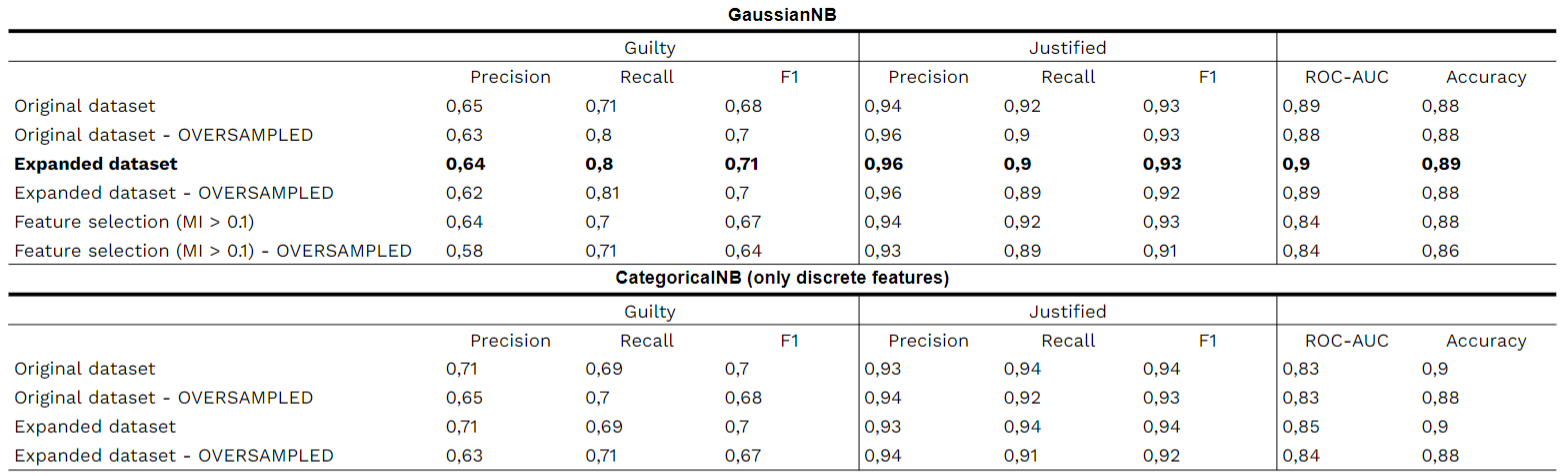

              precision    recall  f1-score   support

           0       0.64      0.80      0.71       414
           1       0.96      0.90      0.93      1938

    accuracy                           0.89      2352
   macro avg       0.80      0.85      0.82      2352
weighted avg       0.90      0.89      0.89      2352




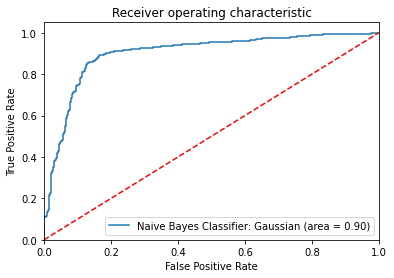

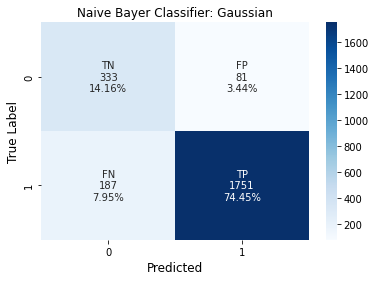

In [ ]:
classifier_gNB = GaussianNB()

classifier_gNB.fit(X_train, y_train)   
y_pred = classifier_gNB.predict(X_test)
print(classification_report(y_test, y_pred))

print()
plot_roc_curve(classifier_gNB, X_test, y_test, 'Naive Bayes Classifier: Gaussian')

print()
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Naive Bayer Classifier: Gaussian')
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

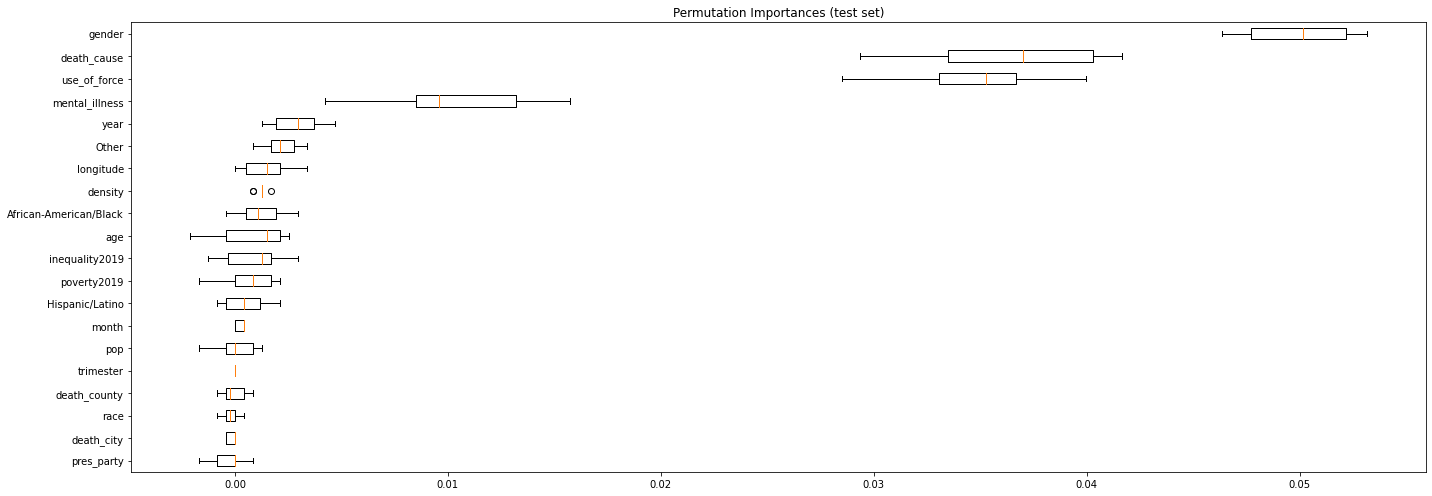

In [ ]:
result = permutation_importance(classifier_gNB, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[-20:]

fig, ax = plt.subplots(figsize=(20,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(police.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
params_LR = {'penalty' : ['None', 'elasticnet', 'l1', 'l2'],
    'C' : np.logspace(-4, 4, 20), 
    'solver': ['newton-cg', 'lbfgs', 'liblinear'], 
    }

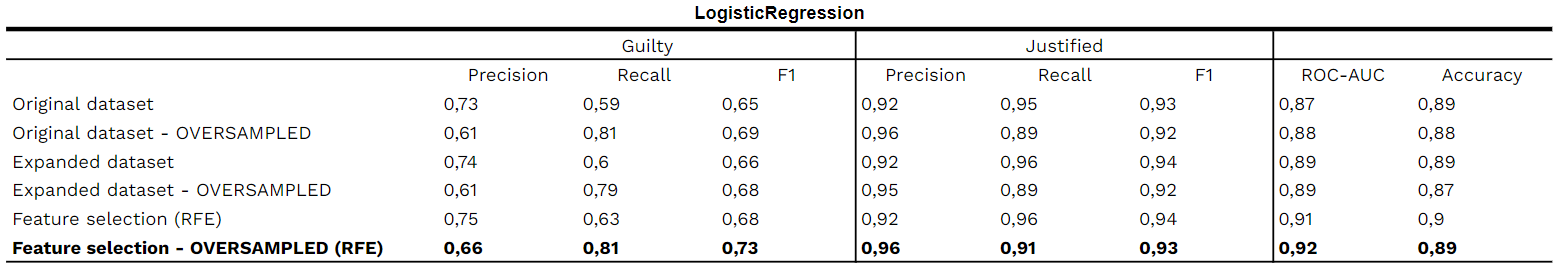

The `death_cause` feature would be more explanatory if converted to dummy variables as the cause of a person's death would seem to be a determining factor for the prediction of the verdict and an ordinal scale would not make much sense.

In [ ]:
# dummy variables for 'death_cause'
df_death_cause.head()

Asphyxiated/Restrained  Beaten/Bludgeoned with instrument  ...  Tasered  Vehicle
7                        0                                  0  ...        0        0
44                       1                                  0  ...        0        0
63                       0                                  0  ...        0        0
65                       0                                  0  ...        0        0
92                       0                                  0  ...        0        0

[5 rows x 13 columns]

In [ ]:
# create new df with 'death_cause' dummy variables
police_lr = police.copy()
police_lr = pd.concat([police_lr, df_death_cause],axis=1).drop('death_cause',axis=1) 

**Logistic Regression Assumptions**

1.   Binary logistic regression requires the dependent variable to be binary.
2.   For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
3.   Only the meaningful variables should be included.
4.   **The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.**
5.   The independent variables are linearly related to the log odds.
6.   Logistic regression requires quite large sample sizes.

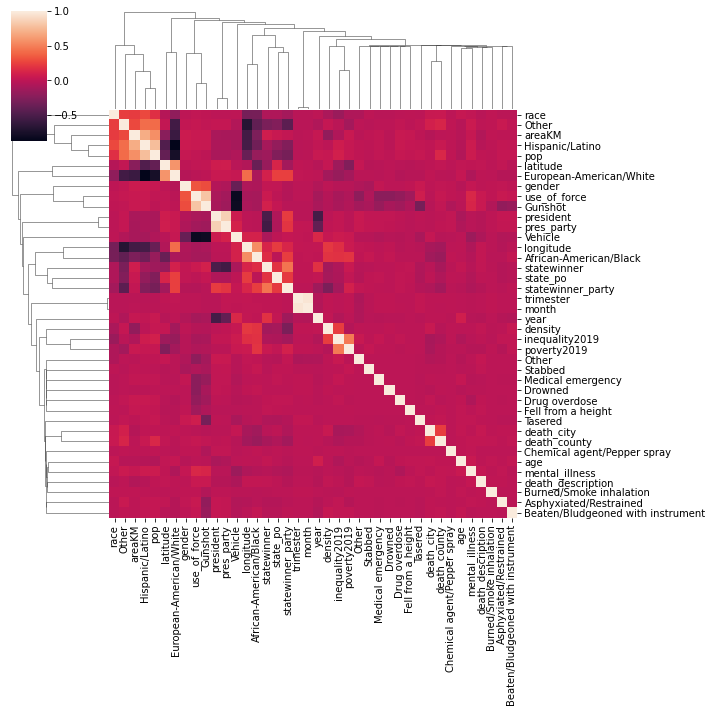

In [ ]:
# plot the clustermap to find multicollinearity
sns.clustermap(police_lr.corr(), xticklabels=police_lr.corr().columns, yticklabels=police_lr.corr().columns, annot=False)
plt.show()

# drop high correlated variables
police_lr.drop(columns=['pres_party', 'trimester'], inplace=True)

In [ ]:
# Preprocessing 

# Split new df in train and test 
X_train_lr, X_test_lr, y_train, y_test = train_test_split(police_lr, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 

# Normalize
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

# Create an oversampled version of new dataset with SMOTE
smote_over = SMOTE(random_state=42)
X_train_lr_over, y_train_over = smote_over.fit_resample(X_train_lr, y_train)

print('Normal\t\t', X_train_lr.shape, y_train.shape,
      '\nOversampled\t', X_train_lr_over.shape, y_train_over.shape)

Normal		 (5486, 38) (5486, 1) 
Oversampled	 (9038, 38) (9038, 1)


In [ ]:
from sklearn.feature_selection import RFECV

estimator = LogisticRegression(random_state=42)
rfecv = RFECV(estimator=estimator, 
              cv = cv_method,
              scoring="f1", 
              verbose=True, n_jobs=-1)

#rfecv.fit(X_train_lr_over, y_train_over)

In [ ]:
rfecv.n_features_ = 28

In [ ]:
print("The optimal number of features: {}".format(rfecv.n_features_))

The optimal number of features: 28


In [ ]:
rfecv.support_ = [ True,  True, False,  True,  True, False, False, False,  True,

       False, False,  True,  True,  True,  True,  True,  True,  True,

        True, False, False, False,  True,  True,  True,  True,  True,

       False,  True,  True,  True,  True,  True,  True,  True,  True,

        True,  True]

In [ ]:
X_train_rfe_over = X_train_lr_over[:, rfecv.support_]
X_test_rfe = X_test_lr[:, rfecv.support_]
police_lr_rfe = police_lr.iloc[:, rfecv.support_]

In [ ]:
print("X shape:\t {}".format(X_train_lr_over.shape))
print("X columns:\t", police_lr.columns.tolist())

print("\nX_rfe shape:\t {}".format(X_train_rfe_over.shape))
print("X_rfe columns:\t", police_lr_rfe.columns.tolist())

print("\nDiscarded variables:", list(set(police_lr.columns.tolist()) - set(police_lr_rfe.columns.tolist())))

categorical_attrs_lr = set(categorical_attrs).intersection(set(police_lr_rfe.columns))

X shape:	 (9038, 38)
X columns:	 ['age', 'gender', 'race', 'mental_illness', 'use_of_force', 'death_city', 'death_county', 'latitude', 'longitude', 'death_description', 'state_po', 'inequality2019', 'poverty2019', 'European-American/White', 'African-American/Black', 'Hispanic/Latino', 'Other', 'areaKM', 'pop', 'density', 'statewinner_party', 'statewinner', 'president', 'year', 'month', 'Asphyxiated/Restrained', 'Beaten/Bludgeoned with instrument', 'Burned/Smoke inhalation', 'Chemical agent/Pepper spray', 'Drowned', 'Drug overdose', 'Fell from a height', 'Gunshot', 'Medical emergency', 'Other', 'Stabbed', 'Tasered', 'Vehicle']

X_rfe shape:	 (9038, 28)
X_rfe columns:	 ['age', 'gender', 'mental_illness', 'use_of_force', 'longitude', 'inequality2019', 'poverty2019', 'European-American/White', 'African-American/Black', 'Hispanic/Latino', 'Other', 'areaKM', 'pop', 'president', 'year', 'month', 'Asphyxiated/Restrained', 'Beaten/Bludgeoned with instrument', 'Chemical agent/Pepper spray', 'Dro

In [ ]:
lr_classifier = LogisticRegression()
# Create grid search object
gs_LR = GridSearchCV(estimator = lr_classifier, 
                     param_grid = params_LR, 
                     cv = cv_method, 
                     scoring='f1', 
                     verbose=True, n_jobs=-1)

# Fit on data
#gs_LR.fit(X_train_rfe_over, y_train_over)
#gs_LR.best_params_

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       414
           1       0.96      0.91      0.93      1938

    accuracy                           0.89      2352
   macro avg       0.81      0.86      0.83      2352
weighted avg       0.91      0.89      0.90      2352




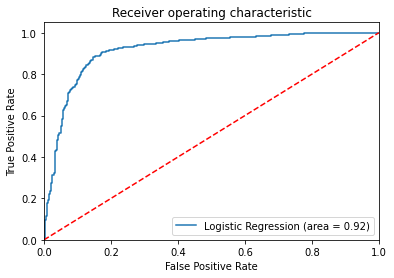

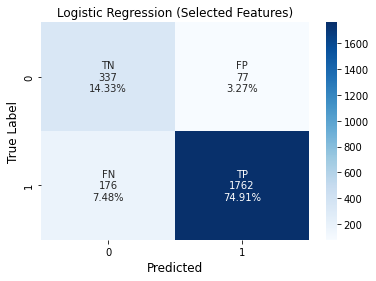

In [ ]:
clf = LogisticRegression(C = 1.623776739188721, 
                         penalty = 'l1', 
                         solver = 'liblinear', 
                         random_state = 42, max_iter = 1000)

clf.fit(X_train_rfe_over, y_train_over)
y_pred = clf.predict(X_test_rfe)
print(classification_report(y_test, y_pred))
    
print()
plot_roc_curve(clf, X_test_rfe, y_test, 'Logistic Regression')

print()
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Logistic Regression (Selected Features)')
plt.show()

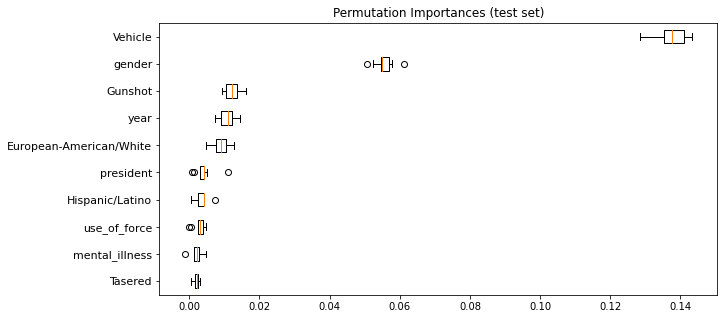

In [ ]:
result = permutation_importance(clf, X_test_rfe, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()[-10:]

fig, ax = plt.subplots(figsize=(10,5))
plt.yticks(fontsize=11)

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(police_lr_rfe.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
plt.show()

## Support Vector Machine (SVM)

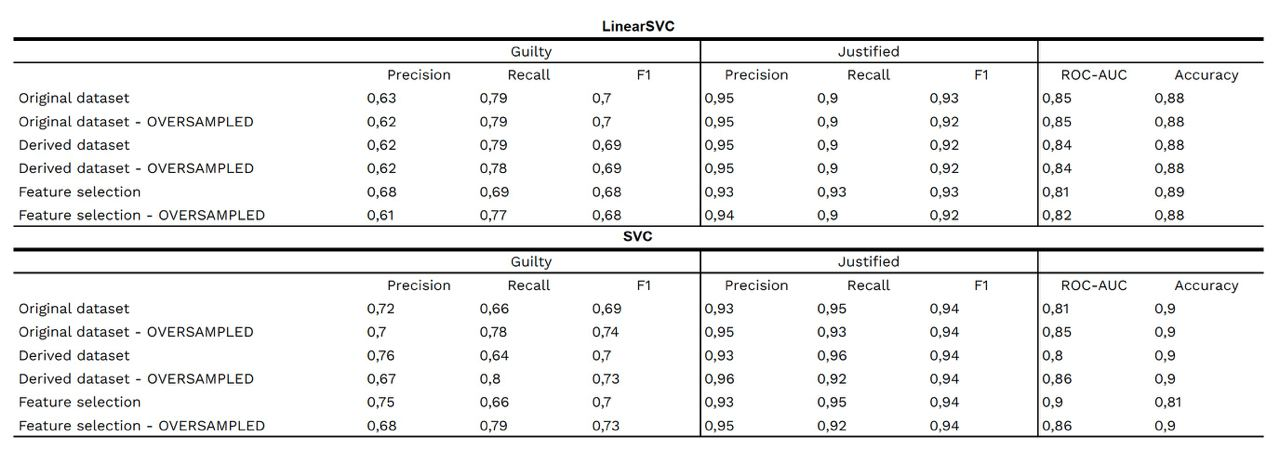

In [ ]:
from sklearn.svm import SVC

params = {
    'C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2, 2.5, 3],
    'kernel': ['linear', 'poly', 'rbf']
}

# coarse grid search
model = SVC(verbose=1, random_state=42)

cv = RepeatedKFold(n_splits=10, n_repeats=3,random_state=42)
#rs_smote = GridSearchCV(estimator=model, param_grid=params, cv=cv, verbose=True, n_jobs=-1)
#rs_result_smote = rs_smote.fit(X_train_over, y_train_over)
#print(f"best parameters:\n{rs_result_smote.best_params_}\naccuracy: {rs_result_smote.best_score_}")

In [ ]:
svm_smote = SVC(C=1.75, kernel='rbf', verbose=1, probability=True, random_state=42)
svm_smote.fit(X_train_over,y_train_over)

[LibSVM]

SVC(C=1.75, probability=True, random_state=42, verbose=1)

In [ ]:
prediction_svm_smote = svm_smote.predict(X_test)
print(classification_report(y_test,prediction_svm_smote))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73       414
           1       0.96      0.92      0.94      1938

    accuracy                           0.90      2352
   macro avg       0.82      0.86      0.83      2352
weighted avg       0.91      0.90      0.90      2352



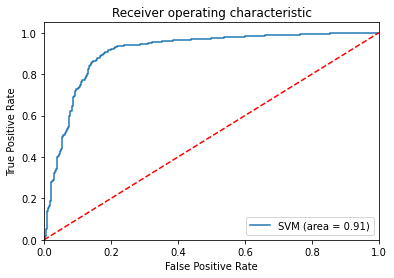

In [ ]:
plot_roc_curve(svm_smote, X_test, y_test, 'SVM')

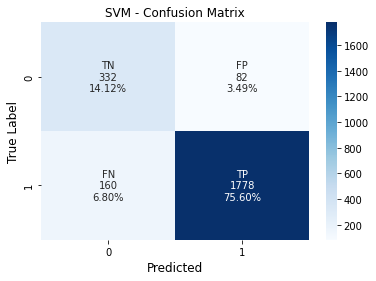

In [ ]:
cf_matrix = confusion_matrix(y_test, prediction_svm_smote)
make_confusion_matrix(cf_matrix, 'SVM - Confusion Matrix')

## Neural Network

Result obtained in different DataSet. In aggregated data the chosen configuration was not able even to surpass Dummy Classifiers performances

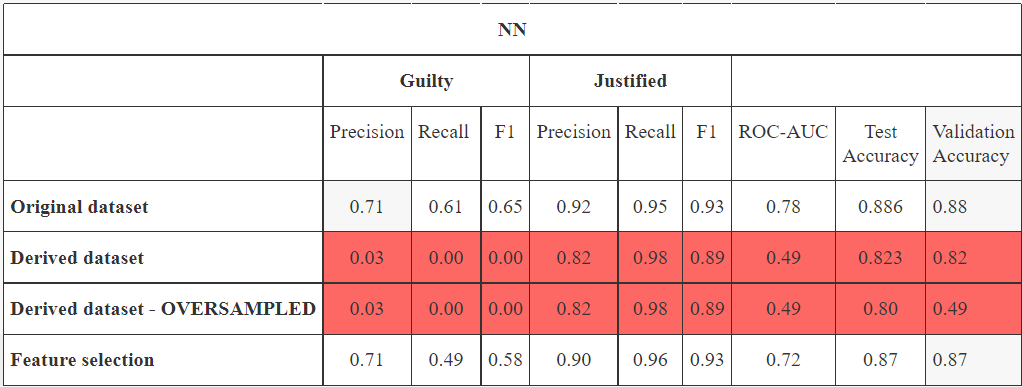

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
# Used for L2 regularization
from tensorflow.keras import regularizers
# Used for dropout
from tensorflow.keras.layers import Dropout
# Used for early stopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Used for L2 regularization
from tensorflow.keras import regularizers
# Used for dropout
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD, Adamax, RMSprop, Adagrad, Adam
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm
from tensorflow.keras.losses import MeanSquaredError
from keras import backend as K
import tensorflow as tf
from datetime import datetime
# Used for early stopping
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import preprocessing

Function to build the model: 
- 1 Hidden Layer
- It can support Dropout, Regularization and different Optimizers

In [ ]:
def build_model(neurons=1, dropout_rate=0.0, weight_constraint=0, activation='sigmoid', learn_rate=0.001, momentum=0,
                reg_value=0, optimizer='adam', init_mode='uniform'):
    tf.keras.backend.clear_session()
    # Build the model
    model_1 = Sequential()

    if reg_value != 0:
        # Apply regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation,
                        kernel_initializer=init_mode,
                        kernel_constraint=maxnorm(weight_constraint),
                        kernel_regularizer=regularizers.l2(reg_value),
                        bias_regularizer=regularizers.l2(reg_value), )
        layer_3 = Dense(1, activation='sigmoid')
    else:
        # No regularization
        layer_1 = Dense(neurons, input_dim=n_features, activation=activation)
        layer_3 = Dense(1, activation='sigmoid')

    model_1.add(layer_1)

    if dropout_rate != 0:
        # Add dropout, seed for reproducibility
        model_1.add(Dropout(dropout_rate, seed=123))

    model_1.add(layer_3)

    # Compile the model
    if optimizer == 'SGD':
        # With clipping
        opt = SGD(learning_rate=learn_rate, momentum=momentum, clipnorm=1.0)
    elif optimizer == 'Adamax':
        # With clipping
        opt = Adamax(learning_rate=learn_rate, name="Adamax", clipnorm=1.0)
    elif optimizer == 'RMSprop':
        # With clipping
        opt = RMSprop(learning_rate=learn_rate, rho=0.9, momentum=momentum,
                      epsilon=1e-07, centered=False, name="RMSprop", clipnorm=1.0)
    elif optimizer == 'Adagrad':
        # With clipping
        opt = Adagrad(learning_rate=learn_rate, initial_accumulator_value=0.1,
                      epsilon=1e-07, name="Adagrad", clipnorm=1.0)
    else:
        # Adam
        # With clipping
        opt = Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999,
                   epsilon=1e-07, amsgrad=False, name="Adam", clipnorm=1.0)

    model_1.compile(loss=MeanSquaredError(), optimizer=opt,
                    metrics=['accuracy'])

    return model_1

Function to manage Batch Size, Number of Epochs and Early Stopping application

In [ ]:
def multiple_configs(model, n_epochs = 750, early_stopping = False, n_TR_patterns = 0):
    # Batch version
  min_epochs = n_epochs
  if early_stopping:
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=n_TR_patterns, callbacks=[early_val_loss]).history
  if early_val_loss.stopped_epoch != 0 and early_val_loss.stopped_epoch < min_epochs:
        min_epochs = early_val_loss.stopped_epoch
  else:
      history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, batch_size=n_TR_patterns).history
    
  print('\n\nPerformance della configurazione sul validation set\n')
  val_results = model.evaluate(X_val, y_val, verbose=1)
  print(f'Validation results - Loss: {val_results[0]} - Accuracy: {val_results[1]}%\n\n\n')

  return history

Early Stopping criteria: it controls Loss and Accuracy on the Validation Set

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_val_loss = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=100,
    mode="min",
    restore_best_weights=True,
)

early_val_accuracy = EarlyStopping(
    monitor="val_accuracy",
    patience=100,
    mode="max",
    restore_best_weights=True,
)

In [ ]:
# Use original data, aggregated data from external sources are removed
tree_sel = police.copy()
tree_sel.drop(['trimester','inequality2019', 'poverty2019', 'state_po', 'European-American/White', 'African-American/Black', 'Hispanic/Latino', 'Other', 'areaKM', 'statewinner_party',
         'statewinner', 'president', 'pres_party', 'pop', 'density', 'death_description'], axis=1, inplace=True)            
tree_sel.head()

age  gender  race  mental_illness  ...   latitude   longitude  year  month
7    20       1     1               1  ...  38.599099 -121.285771  2000      9
44   31       1     2               1  ...  34.268842 -118.415827  2000      9
63   85       1     1               2  ...  33.747926 -116.959916  2000      2
65   23       1     2               1  ...  34.024327 -117.425389  2000      5
92   25       1     1               2  ...  32.726607 -117.071753  2000      1

[5 rows x 12 columns]

In [ ]:
#specify class and features
class_name = 'dispositions_exclusions'
attributes = [col for col in tree_sel if col != class_name]

#Train and Test Sets definition
X = tree_sel[attributes].values
y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=target)

#Normalize
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#we split the training set in training and validation set, using as validation 30% of the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

Grid Search Parameter List used

In [ ]:
#model_grid = KerasRegressor(build_fn=build_model, verbose=0)
learn_rate = [0.1, 0.01, 0.001]
momentum = [0, 0.3, 0.5]
optimizer = ['Adam', 'SGD']
init_mode = ['he_normal', 'he_uniform']
batch_size = [1920]
epochs = [1000]
weight_constraint = [1,2]
dropout_rate = [0, 0.1, 0.2,0.3]
neurons = [5,7,10,15]
reg_value = [0, 0.001, 0.01, 0.1]

Grid Search Code. It will not be executed because it takes a lot of time

In [ ]:
#datetime object containing current date and time
#print('\ninizio:', datetime.now())
#param_grid = dict(neurons=neurons, dropout_rate=dropout_rate, weight_constraint=weight_constraint, optimizer=optimizer,
                  #batch_size=batch_size, epochs=epochs, learn_rate=learn_rate, momentum=momentum, init_mode=init_mode,
                  #reg_value = reg_value)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=5, cv=3, scoring='neg_mean_squared_error')
#grid_result = grid.fit(X_train, y_train)
#print('\nfine:', datetime.now())
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

Building the best model found, using grid search parameters

In [ ]:
#Current BEST model
n_features = X_train.shape[1]
model = build_model(init_mode='he_uniform', learn_rate= 0.1, neurons=10, dropout_rate=0, weight_constraint=1, optimizer='SGD', momentum=0.5, reg_value=0)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


Launch the Neural Network, using Early Stopping Criteria to avoid overfitting/uderfitting and using a Batch Size equal to half of training set

In [ ]:
history = multiple_configs(model, n_epochs=2000, early_stopping=True, n_TR_patterns=1920)

Epoch 1/2000
2/2 [==============================] - 1s 158ms/step - loss: 0.2383 - accuracy: 0.6607 - val_loss: 0.2258 - val_accuracy: 0.7272
Epoch 2/2000
2/2 [==============================] - 0s 45ms/step - loss: 0.2215 - accuracy: 0.7430 - val_loss: 0.2079 - val_accuracy: 0.8007
Epoch 3/2000
2/2 [==============================] - 0s 26ms/step - loss: 0.2046 - accuracy: 0.7990 - val_loss: 0.1936 - val_accuracy: 0.8202
Epoch 4/2000
2/2 [==============================] - 0s 27ms/step - loss: 0.1915 - accuracy: 0.8188 - val_loss: 0.1832 - val_accuracy: 0.8226
Epoch 5/2000
2/2 [==============================] - 0s 25ms/step - loss: 0.1820 - accuracy: 0.8232 - val_loss: 0.1757 - val_accuracy: 0.8238
Epoch 6/2000
2/2 [==============================] - 0s 31ms/step - loss: 0.1751 - accuracy: 0.8237 - val_loss: 0.1701 - val_accuracy: 0.8238
Epoch 7/2000
2/2 [==============================] - 0s 28ms/step - loss: 0.1699 - accuracy: 0.8237 - val_loss: 0.1660 - val_accuracy: 0.8238
Epoch 8/2000

Learning Curve, it shows both Accuracy and Loss on the Training and Validation Sets among the Epochs

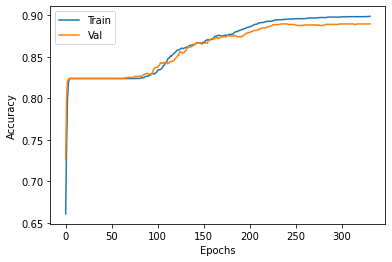

 --- --- --- --- --- 


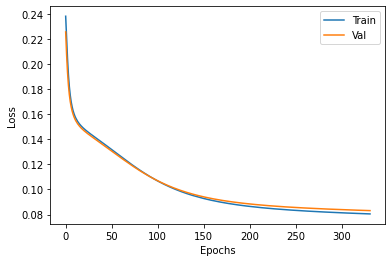

In [ ]:
plt.plot(history['accuracy'], label='Train')
plt.plot(history['val_accuracy'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(' --- --- --- --- --- ')

plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Set results

In [ ]:
# Test the basic model
test_results = model.evaluate(X_test, y_test, verbose=0)
print(f'Test results, basic model \n Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

Test results, basic model 
 Loss: 0.08821889758110046 - Accuracy: 0.8860543966293335%


The output of the network is the probability that an instance is 0 or 1 class, so we transform that probability in the class value in order to perform confusion matrix and roc curve

In [ ]:
y_pred = model.predict(X_test)

for i in range (0, y_pred.size):
  if(y_pred[i] >= 0.5):
    y_pred[i] = 1
  else:
    y_pred[i] = 0

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       414
           1       0.93      0.93      0.93      1938

    accuracy                           0.89      2352
   macro avg       0.80      0.80      0.80      2352
weighted avg       0.89      0.89      0.89      2352

--- --- --- --- ---


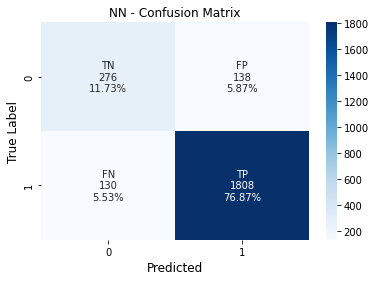

In [ ]:
print(classification_report(y_test, y_pred))

print("--- --- --- --- ---")
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'NN - Confusion Matrix')

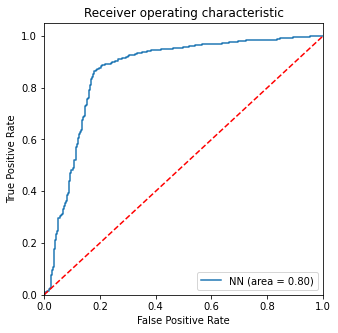

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test))
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='NN (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('KNN ROC Curve')
plt.show()

# Comparisons and Conclusions


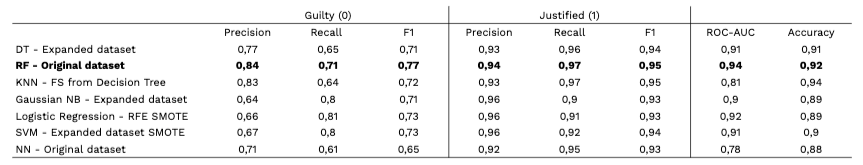

We chose Random Forest both because shows the best performances on the F1 on the minority class and on the ROC-AUC score and because it performes so well only using the original dataset.